In [3]:
using Fretem, Potential, Alphabeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

### Part 1: Get collocation points and integration kernel for whole domain

In [5]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 20 # unit: angstrom
xavg = 50   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V_{eq}(x)$ and $p_{eq}(x)$

In [8]:
k_eq = 0.5 # unit: kcal/mol/angstrom^2
sigma_by_keq = 1 / sqrt(2 * k_eq)
V_eq = harmonic_well_k_mean(xref, k_eq, xavg)
rho_eq = get_rhoeq(V_eq, w0)
peq = rho_eq .* rho_eq
D = 4.845e9 # Diffusion coefficient, unit: angstrom^2 s-1
## Photon Operator
k_photon = 3. # unit: kcal/mol/angstrom^2
sigma_photon = 1 / sqrt(2 * k_photon);

### Part 3: Read Trajectory

#### physical parameters about simulations

In [9]:
save_freq = 1e-9 # unit: s, Save trajectory per 100 ps
total_times = 10e-6 # unit: s, totol simulate 10 us, 10e-6
dt = 1e-11 # unit: s  # Integration Times 1ps
#kbT = 1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 100 timesteps. There will be 10000 data points.


#### read simulated trajectory from jld file

In [5]:
f_in = "../trajectory/k_1_tsim_10us_deltat_1ns.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D"); # Diffusion coefficient, unit: angstrom^2 s-1

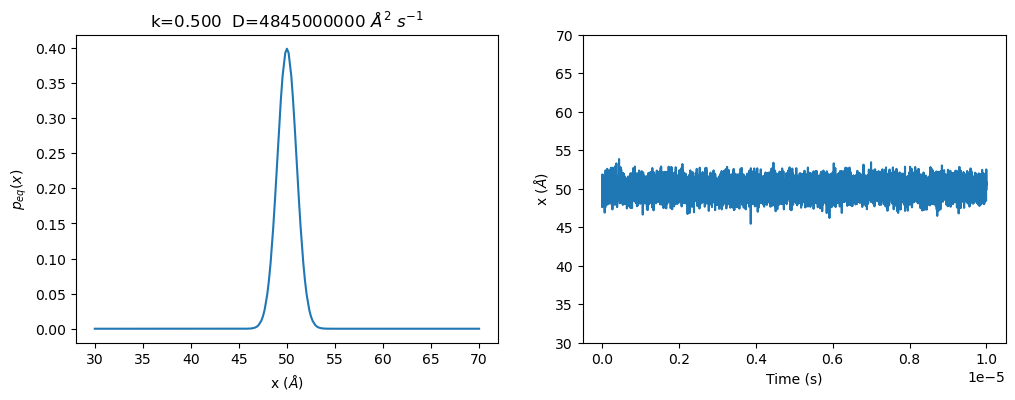

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, rho_eq .* rho_eq)
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")
title = @sprintf "k=%.3f  D=%.0f \$\\AA^2~ s^{-1}\$" k_ref D
ax.set_title(title)

ax = axes[2]
ax.plot(t_record, y_record)
ax.set_xlabel("Time (s)")
ax.set_ylabel("x (\$ \\AA \$)")
ax.set_ylim(30,70)
#plt.savefig("Simu_for_EM.png", dpi=200)
plt.show()

### Part 4: Get eigenvalues and eigenvectors

In [10]:
Nv = 72 # Number of eigenvectors
Lambdas, Qx, rho = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, peq, D, Nv);

### Part 5: Initial guess $p^0_{eq}(x)$ Batch Run

In [8]:
for xavg_guess in [30. 35. 40. 45. 55. 60. 65. 70.]
    k = 0.1 # unit: kcal/mol/angstrom^2
    V = harmonic_well_k_mean(xref, k, xavg_guess)
    rho = get_rhoeq(V, w0)
    p = rho .* rho;
    
    # Set iteration number and initailize container
    n_iteration = 100
    p_container = zeros(Float64, n_iteration+1, N)
    log_likelihood_records = zeros(n_iteration+1)
    
    # Iteration of EM
    p_prev = p
    p_container[1, :] = p # The first row in container is p_0
    for iter_id = 1:n_iteration
        if iter_id % 2 == 0
            print_txt = @sprintf "Position Guess at %.0f: iteration %d starts" xavg_guess iter_id
            println(print_txt)
        end
        p_em, log_likelihood = forward_backward_v2(Nh, Np, xratio, xavg, p_prev, D, Nv, tau, y_record, save_freq)
        log_likelihood_records[iter_id] = log_likelihood
        p_em = max.(p_em, 1e-10)
        p_container[iter_id+1, :] = p_em
        p_prev = zeros(N,1)
        p_prev[:,1] = p_em
    end
    
    # Output
    f_out = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_xavg_%d_pref_xavg_%d_v2.jld" xavg_guess xavg # Ad hoc
    save(f_out, "p_container", p_container)
    println(@sprintf "Write p_container to %s" f_out)
    
    # Output
    f_out = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_xavg_%d_pref_xavg_%d_v2_loglikelihood.jld" xavg_guess xavg # Ad hoc
    save(f_out, "log_likelihood_records", log_likelihood_records)
    println(@sprintf "Write log_likelihood_records to %s" f_out)
    
end

Position Guess at 30: iteration 2 starts
Position Guess at 30: iteration 4 starts
Position Guess at 30: iteration 6 starts
Position Guess at 30: iteration 8 starts
Position Guess at 30: iteration 10 starts
Position Guess at 30: iteration 12 starts
Position Guess at 30: iteration 14 starts
Position Guess at 30: iteration 16 starts
Position Guess at 30: iteration 18 starts
Position Guess at 30: iteration 20 starts
Position Guess at 30: iteration 22 starts
Position Guess at 30: iteration 24 starts
Position Guess at 30: iteration 26 starts
Position Guess at 30: iteration 28 starts
Position Guess at 30: iteration 30 starts
Position Guess at 30: iteration 32 starts
Position Guess at 30: iteration 34 starts
Position Guess at 30: iteration 36 starts
Position Guess at 30: iteration 38 starts
Position Guess at 30: iteration 40 starts
Position Guess at 30: iteration 42 starts
Position Guess at 30: iteration 44 starts
Position Guess at 30: iteration 46 starts
Position Guess at 30: iteration 48 sta

### Part 6: Plot

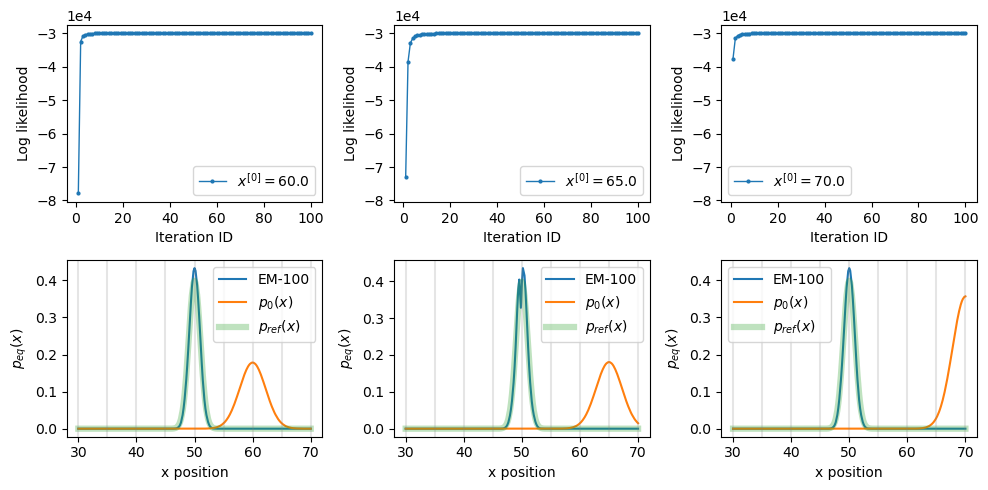

Load p_container from /home/yizaochen/codes/julia/EM_data/p0_xavg_60_pref_xavg_50_v2.jld
Load log_likelihood_records from /home/yizaochen/codes/julia/EM_data/p0_xavg_60_pref_xavg_50_v2_loglikelihood.jld
Load p_container from /home/yizaochen/codes/julia/EM_data/p0_xavg_65_pref_xavg_50_v2.jld
Load log_likelihood_records from /home/yizaochen/codes/julia/EM_data/p0_xavg_65_pref_xavg_50_v2_loglikelihood.jld
Load p_container from /home/yizaochen/codes/julia/EM_data/p0_xavg_70_pref_xavg_50_v2.jld
Load log_likelihood_records from /home/yizaochen/codes/julia/EM_data/p0_xavg_70_pref_xavg_50_v2_loglikelihood.jld


In [35]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,5))

col_id = 1
for xavg_guess in [60.0, 65.0, 70.0]
    k = 0.1 # unit: kcal/mol/angstrom^2
    V = harmonic_well_k_mean(xref, k, xavg_guess)
    rho = get_rhoeq(V, w0)
    p = rho .* rho;
    
    # Read p_em
    f_in = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_xavg_%d_pref_xavg_%d_v2.jld" xavg_guess xavg # Ad hoc
    p_container = load(f_in, "p_container")
    println(@sprintf "Load p_container from %s" f_in)

    # Read log-likelihood
    f_in = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_xavg_%d_pref_xavg_%d_v2_loglikelihood.jld" xavg_guess xavg # Ad hoc
    log_likelihood_records = load(f_in, "log_likelihood_records")
    println(@sprintf "Load log_likelihood_records from %s" f_in)
    
    ax = axes[1, col_id]
    n_iter = length(log_likelihood_records)-1
    xarray = 1:n_iter
    label = @sprintf "\$x^{[0]}=%.1f\$" xavg_guess
    ax.plot(xarray, log_likelihood_records[1:n_iter], "-o", linewidth=1, markersize=2, label=label)
    ax.legend()
    ax.set_xlabel("Iteration ID")
    ax.set_ylabel("Log likelihood")
    ylim = (-80413.014, -27512.933)
    ax.set_ylim(ylim)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    
    ax = axes[2, col_id]
    iter_id = 100
    label = @sprintf "EM-%d" iter_id
    ax.plot(xref, p_container[iter_id+1, :], label=label)
    ax.plot(xref, rho .* rho, label="\$ p_0(x) \$")
    ax.plot(xref, rho_eq .* rho_eq, linewidth=4.5, alpha=0.3, label="\$ p_{ref}(x) \$")
    for xline in 30:5:70
        ax.axvline(xline, color="grey", alpha=0.2)
    end
    ax.legend()
    ax.set_xlabel("x position")
    ax.set_ylabel("\$ p_{eq}(x) \$")
    
    col_id += 1
end

plt.tight_layout()
#plt.savefig("guess_60_65_70.svg")
plt.show()

### Additional Part: Check ylim of log-likelihood plot

In [ ]:
xavglist = [30. 35. 40. 45. 50. 55. 60. 65. 70.]
n_xavg = length(xavglist)
minlist = zeros(n_xavg)
maxlist = zeros(n_xavg)
idx = 1
fig, axes = plt.subplots(nrows=1, ncols=n_xavg, figsize=(10,5))
for xavg_guess in xavglist
    # Read p_em
    f_in = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_xavg_%d_pref_xavg_%d_v2.jld" xavg_guess xavg # Ad hoc
    p_container = load(f_in, "p_container")
    println(@sprintf "Load p_container from %s" f_in)

    # Read log-likelihood
    f_in = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_xavg_%d_pref_xavg_%d_v2_loglikelihood.jld" xavg_guess xavg # Ad hoc
    log_likelihood_records = load(f_in, "log_likelihood_records")
    println(@sprintf "Load log_likelihood_records from %s" f_in)
    
    ax = axes[idx]
    n_iter = length(log_likelihood_records)-1
    xarray = 1:n_iter
    ax.plot(xarray, log_likelihood_records[1:n_iter], "-o", linewidth=1, markersize=2)
    
    ylim = ax.get_ylim()
    minlist[idx] = ylim[1]
    maxlist[idx] = ylim[2]
    
    idx += 1
end

println(@sprintf "Minimum is %.3f" minimum(minlist))
println(@sprintf "Maximum is %.3f" maximum(maxlist))

plt.show()
#minlist = zeros(9)